## Overview

Housing stock is always in short supply in NYC, and costs have risen considerably over time for both [owners](https://comptroller.nyc.gov/reports/spotlight-new-york-citys-homeowner-housing-market/) and [renters](https://comptroller.nyc.gov/reports/spotlight-new-york-citys-rental-housing-market/). Although [new housing](https://github.com/lnagle/code-diary/tree/main/nyc-housing-analysis) is being built all the time, NYC is also subject to extreme weather and sea level rise due to climate change.

The goal of this project is to investigate how climate change will affect housing stock in NYC. We'll do this by using [NYC Open Data sets](https://opendata.cityofnewyork.us/).


## The Lay of the Land

First, let’s get a simple visual of NYC’s boroughs.

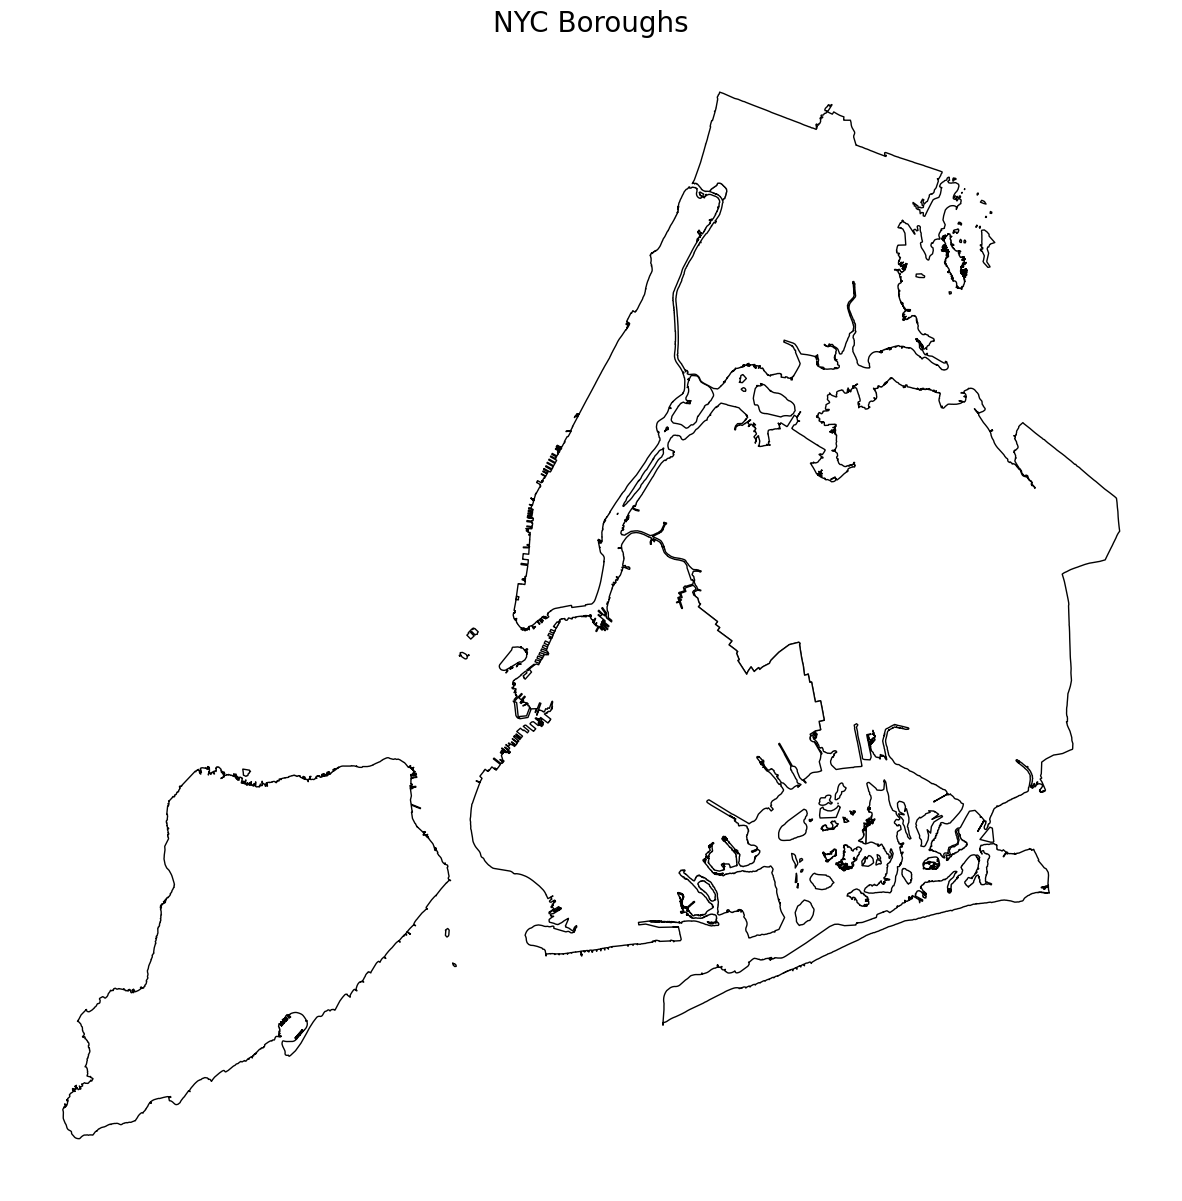

In [29]:
import geopandas
from geodatasets import get_path
import matplotlib.pyplot as plt

path_to_data = get_path("nybb")
nyc_base = geopandas.read_file(path_to_data)

nyc_base = nyc_base.set_index("BoroName")

plot = nyc_base.plot(figsize=(15, 15), color='white', edgecolor='black', linewidth=1)
plot.set_axis_off()
plot.set_title("NYC Boroughs", fontsize=20)

plt.savefig('images/nycBoroughs')

Note: At any point in this demo in which we `.plot()`, we can also use the [`.explore()`](https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html#Interactive-mapping) function. This gives us an interactive map with the ability to zoom in and out, as well as view other metadata about sections of the map. Give it a try!

Now let’s overlay this with projected flooding and sea level rise in 2050. For this step, we'll be using [this data set](https://data.cityofnewyork.us/City-Government/NYC-Stormwater-Flood-Map-Moderate-Flood-with-2050-/5rzh-cyqd/about_data) provided by the NYC Department of Environmental Protection (DEP).

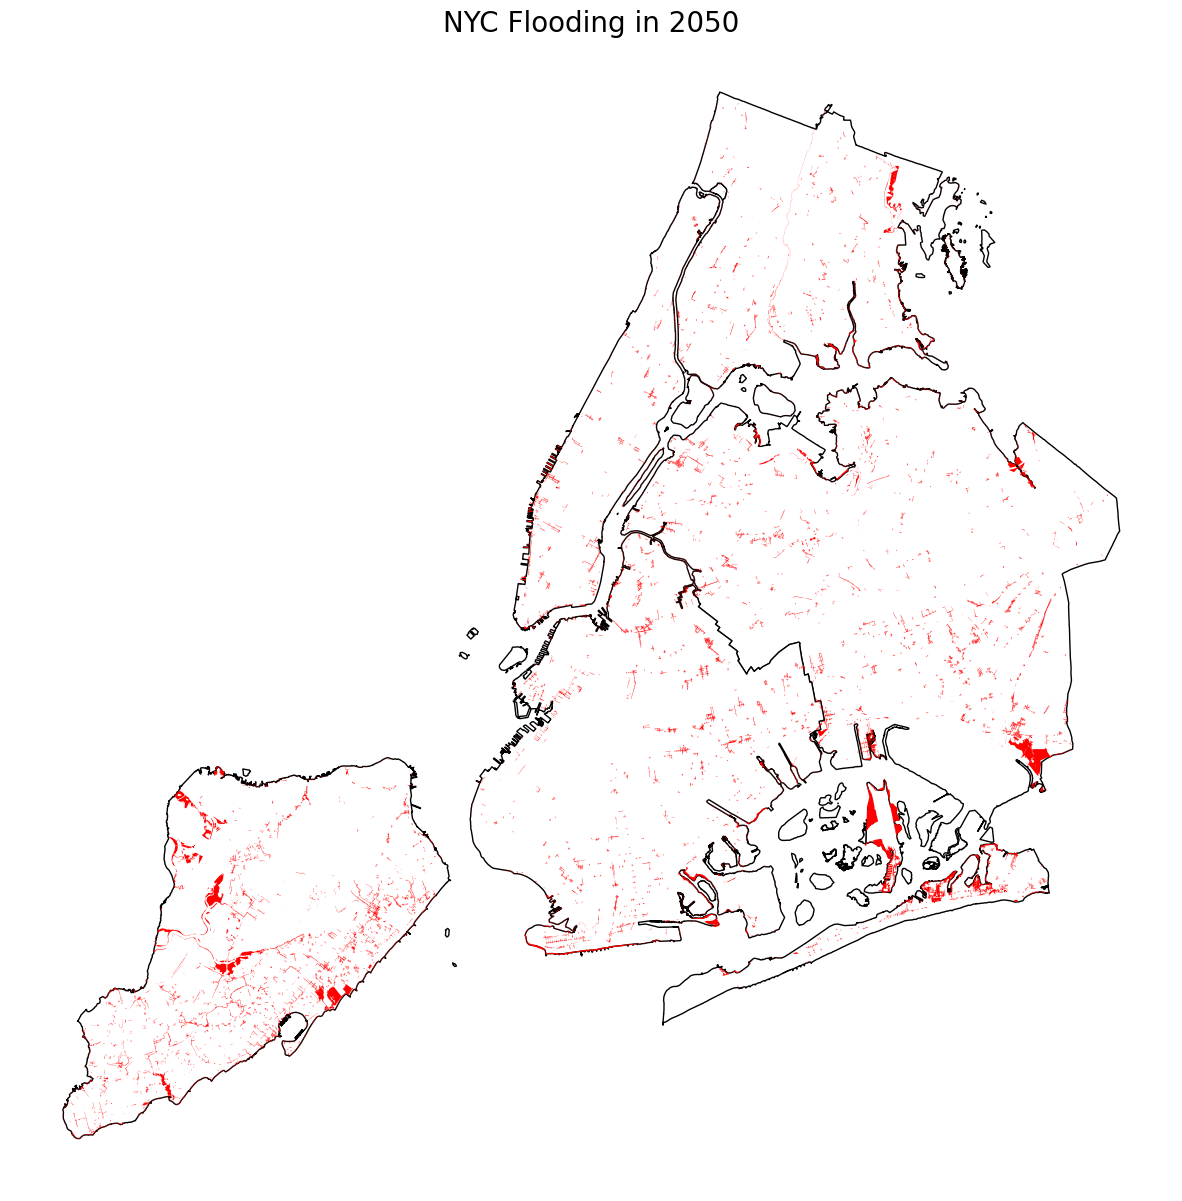

In [30]:
base = nyc_base.plot(figsize=(15, 15), color='white', edgecolor='black', linewidth=1)
base.set_axis_off()

gdf = geopandas.read_file('rawData/floodMapData2050.gdb')

plot = gdf.plot(ax=base, color='red')
plot.set_title("NYC Flooding in 2050", fontsize=20)

plt.savefig('images/flooding2050', dpi=200)

From the data dictionary that comes with our data set, we can see that the areas in red indicate a few different categories of flooding. These flood categories are:

- 1. Nuisance Flooding (greater or equal to 4 in. and less than 1 ft.)
- 2. Deep and Contiguous Flooding (1 ft. and greater)
- 3. Future High Tides in 2050

This first one contains a key caveat about this investigation: we will only be mapping areas that are identified to be _at a minimum_ under 4 inches of water.

With this understanding, let's see what our map looks like if we plot sections 1 and 2 separately from 3.

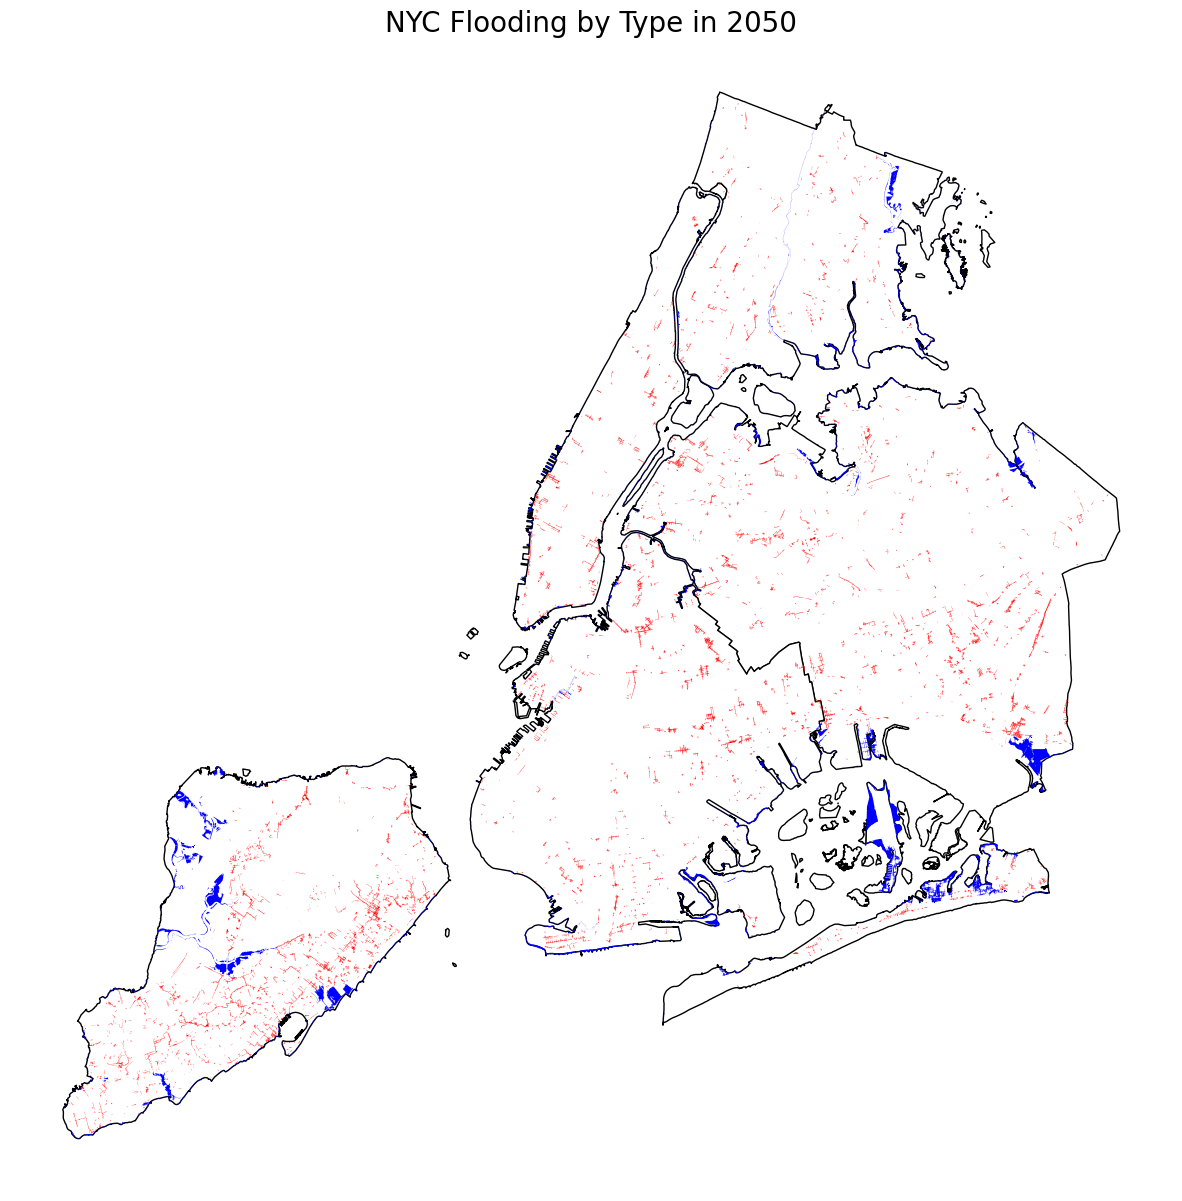

In [32]:

base = nyc_base.plot(figsize=(15, 15), color='white', edgecolor='black', linewidth=1)
base.set_title("NYC Flooding by Type in 2050", fontsize=20)
base.set_axis_off()

gdf = geopandas.read_file('rawData/floodMapData2050.gdb')

# Separate flooding categories from sea level change category 
gdf1 = gdf.head(2)
gdf2 = gdf.tail(1)

gdf1.plot(ax=base, color='red')
gdf2.plot(ax=base, color='blue')

plt.savefig('images/flooding2050SeparatedFloodTypes', dpi=200)

As would be expect, we can see that sea level rise primarily effects the boundaries of each borough, with areas in Staten Island being an exception. It's a little hard from this view to really see the impact of the other two flood categories at a granular level. Let's try using the aforementioned `.explore()` function.

The below code generates a pretty large map file (bigger than GitHub is willing to display), so I'm commenting it out. If you've pulled this repo down, simply uncomment the code and run it as normal

In [20]:
# base = nyc_base.explore(figsize=(15, 15), color='white', edgecolor='black', linewidth=1, tooltip=False)

# # Separate flooding categories from sea level change category 
# gdf1 = gdf.head(2)
# gdf2 = gdf.tail(1)

# gdf1.explore(m=base, color='red', tooltip=False)
# gdf2.explore(m=base, color='blue', tooltip=False)

That's definitely easier to see. A couple technical notes about the above code:

1. We disable tooltips here. If we were to leave them on, we would see a full spread of column info whenever we hover over any of the areas that we plot. This can be super informative, but in the case of our two data sets it's a little noisy
2. An implementation detail: In addition to changing `.plot()` to `.explore()`, we also need to update `ax=base` to `m=base` inside of any subsequent `.plot()` calls after the first. If we forget to, we'll receive an ambiguous JSON serialization error.

Some category 1 and 2 observations from this mapping:

- Flooding will be a widespread problem in NYC, affecting all 5 boroughs.
- Certain neighborhoods and areas will be more affected than others. For example, Red Hook and Gowanus are both subject to widespread flooding, while Park Slope to the east is not.
- While there's obvious risk associated with areas that are close to the water, the situation is not that simple. We can see widespread flooding in the interiors of Brooklyn and Queens, for example.
- We don't have enough information from this mapping alone to draw conclusions about which borough will be most affected by climate change.

One final note about this mapping: 

As mentioned above, we're only viewing areas of flooding with depths of 4 inches or greater. This doesn’t mean that areas not highlighted on this map won't be affected. Anecdotally, I recall walking around my neighborhood, Fort Greene, after very heavy rains at the end of April 2023 and seeing many homeowners using water pumps to drain their basements and garden levels. Fort Greene, if you look closely, actually has very little flooding on our map. Which is to say that the data set we’re using may actually have quite a high bar for what flooding is. We need to keep this in mind throughout our analysis; extreme weather has impacts at a scale worthy of high-level, bird's eye view analysis, but at the end of the day it's causing signficant upheaval in the lives of individuals on the ground.